In [1]:
import pandas as pd
import numpy as np

loan = pd.read_csv('ori_data/loan_activities.csv')
nb = pd.read_csv('ori_data/non_borrower_user.csv')
train = pd.read_csv('ori_data/train.csv')
test = pd.read_csv('ori_data/test.csv')

print(loan.shape)
print(nb.shape)
print(train.shape)
print(test.shape)

(4300999, 4)
(2474949, 18)
(857899, 19)
(367702, 18)


In [2]:
loan

,user_id,reference_contact,loan_type,ts
0,2223129,903716,1,671
1,1380939,484583,1,89
2,2724411,1185034,1,230
3,2401751,1369254,1,120
4,1982168,21797,1,57
...,...,...,...,...
4300994,468400,2004356,11,493
4300995,2844279,1657495,11,609
4300996,1071963,2316823,11,1
4300997,2803447,3513529,11,367


In [3]:
loan_dup = loan[loan.duplicated(subset='user_id', keep=False)]
print(len(loan_dup))

3351830


In [4]:
loan_dup.sort_values(by='user_id')

,user_id,reference_contact,loan_type,ts
4028410,5,176154,10,116
2534442,5,2191460,5,759
1890975,9,3574121,5,450
1003955,9,609079,4,153
831098,9,1611064,4,350
...,...,...,...,...
3429190,3700544,1656022,6,259
2109344,3700544,2561688,5,521
188701,3700544,2921812,1,259
1547768,3700547,1334850,5,505


***Feature Importance Analysis - User, Reference Contact, and their relationship***

In [5]:
check_fraud = loan.copy()
check_fraud.sort_values(by='user_id', inplace=True)

check_fraud = check_fraud.merge(train[['user_id', 'label']], on='user_id', how='left')

check_fraud['id_in_train'] = check_fraud['user_id'].isin(train['user_id']).astype(int)
check_fraud['id_in_test'] = check_fraud['user_id'].isin(test['user_id']).astype(int)
check_fraud['id_in_nb'] = check_fraud['user_id'].isin(nb['user_id']).astype(int)


check_fraud['ref_in_train'] = check_fraud['reference_contact'].isin(train['user_id']).astype(int)
check_fraud['ref_in_test'] = check_fraud['reference_contact'].isin(test['user_id']).astype(int)
check_fraud['ref_in_nb'] = check_fraud['reference_contact'].isin(nb['user_id']).astype(int)

columns_order = [col for col in check_fraud.columns if col != 'label'] + ['label']
check_fraud = check_fraud[columns_order]

check_fraud

,user_id,reference_contact,loan_type,ts,id_in_train,id_in_test,id_in_nb,ref_in_train,ref_in_test,ref_in_nb,label
0,1,2592936,2,423,0,0,1,0,1,0,NaN
1,5,176154,10,116,1,0,0,0,0,1,0.0
2,5,2191460,5,759,1,0,0,0,0,1,0.0
3,7,2265784,11,594,0,0,1,0,1,0,NaN
4,9,1611064,4,350,1,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4300994,3700544,2921812,1,259,0,1,0,1,0,0,NaN
4300995,3700546,2059738,4,665,0,0,1,0,0,1,NaN
4300996,3700547,376240,5,505,0,0,1,0,0,1,NaN
4300997,3700547,1334850,5,505,0,0,1,0,0,1,NaN


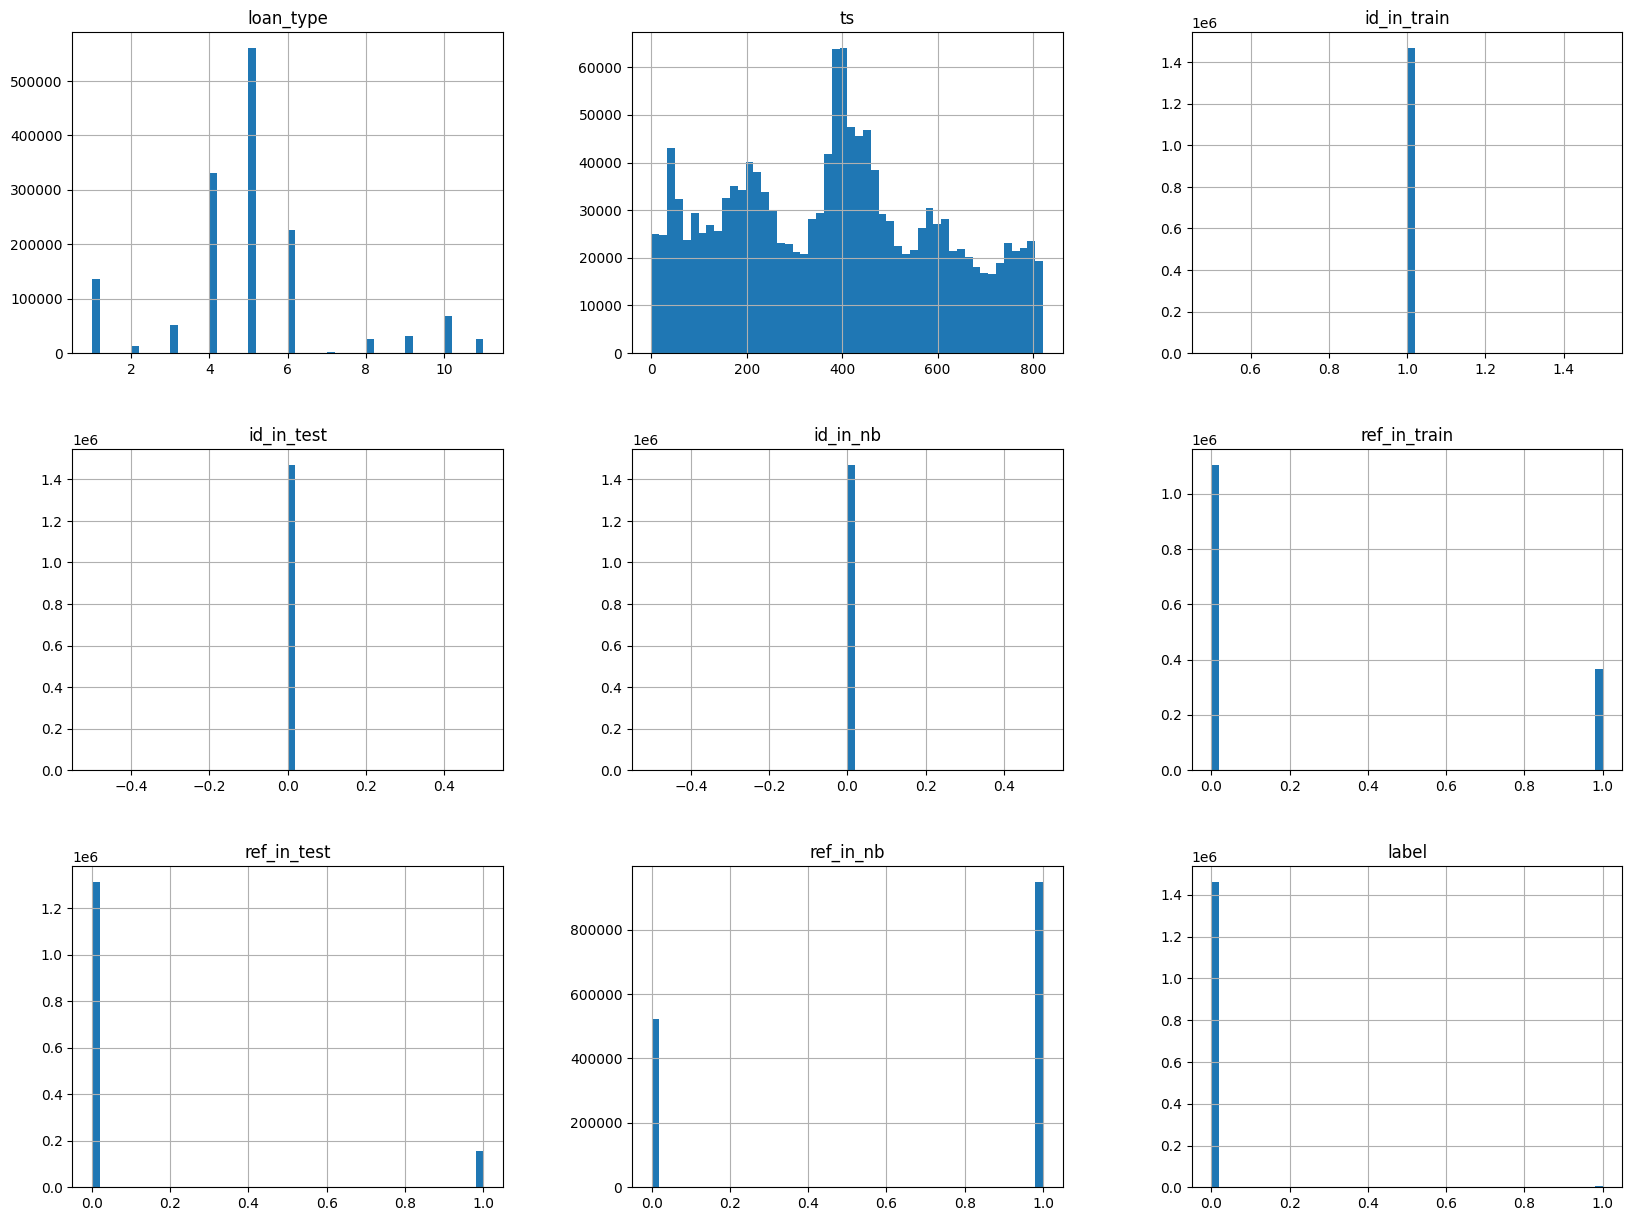

In [6]:
import matplotlib.pyplot as plt

labeled = check_fraud[check_fraud['label'].notnull()]

labeled_for_check = labeled.drop(columns=['user_id', 'reference_contact'])
labeled_for_check.hist(bins = 50, figsize = (20,15))

plt.show()

In [7]:
labeled_for_check.dtypes

loan_type         int64
ts                int64
id_in_train       int64
id_in_test        int64
id_in_nb          int64
ref_in_train      int64
ref_in_test       int64
ref_in_nb         int64
label           float64
dtype: object

In [8]:
from scipy.stats import chi2_contingency

binary_features = ['id_in_train', 'id_in_test', 'id_in_nb', 'ref_in_train', 'ref_in_test', 'ref_in_nb']

for feature in binary_features:
    contingency_table = pd.crosstab(labeled_for_check[feature], labeled_for_check['label'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Feature: {feature}, p-value: {p}")

Feature: id_in_train, p-value: 1.0
Feature: id_in_test, p-value: 1.0
Feature: id_in_nb, p-value: 1.0
Feature: ref_in_train, p-value: 3.6477571703642255e-42
Feature: ref_in_test, p-value: 1.3425721603354271e-12
Feature: ref_in_nb, p-value: 7.360021060291439e-64


*Result of Chi-Squared Test = Reference_contact have more importance*

In [9]:
from scipy.stats import f_oneway

# Group the data by loan_type
groups = [labeled_for_check[labeled_for_check['loan_type'] == t]['label'] for t in labeled_for_check['loan_type'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA result for loan_type: F-statistic = {f_stat}, p-value = {p_value}")

ANOVA result for loan_type: F-statistic = 466.6329422208236, p-value = 0.0


*Result of ANOVA = loan_type MATTERS.*

In [10]:
correlation_matrix = labeled_for_check.corr()
print(correlation_matrix['label'].sort_values(ascending=False))

label           1.000000
loan_type       0.035893
ref_in_nb       0.013919
ref_in_test    -0.005860
ref_in_train   -0.011229
ts             -0.041149
id_in_train          NaN
id_in_test           NaN
id_in_nb             NaN
Name: label, dtype: float64


*Result of Corr Matrix = loan_type and ref_in_nb berbanding lurus, nb berbanding terbalik.*

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Assuming check_fraud is already prepared as described earlier
# Normalize the timestamp (ts) column
scaler = MinMaxScaler()
check_fraud['ts'] = scaler.fit_transform(check_fraud[['ts']])

# Prepare the feature set and target variable
features = ['loan_type', 'ts', 'id_in_train', 'id_in_test', 'id_in_nb',
            'ref_in_train', 'ref_in_test', 'ref_in_nb']
X = check_fraud[features]
y = check_fraud['label']

# Remove rows with missing labels (if any)
X = X[y.notnull()]
y = y.dropna()

# Convert boolean columns to integers (0 and 1)
X = X.astype(int)

# Initialize and fit the logistic regression model
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X, y)

# Evaluate feature importance
importance = logreg.coef_[0]

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})

# Print the feature importance
print(feature_importance)

# Optional: Print classification report to evaluate the model
y_pred = logreg.predict(X)
print(classification_report(y, y_pred))

        Feature  Importance
0     loan_type    0.193362
1            ts   -1.179548
2   id_in_train    0.000576
3    id_in_test    0.000000
4      id_in_nb    0.000000
5  ref_in_train   -0.126705
6   ref_in_test   -0.081210
7     ref_in_nb    0.208490


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   1463095
         1.0       0.00      0.00      0.00      7995

    accuracy                           0.99   1471090
   macro avg       0.50      0.50      0.50   1471090
weighted avg       0.99      0.99      0.99   1471090



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Important features so far:

1. ts (the higher, the less likely fraudulent)

2. loan_type (the higher, the more likely fraudulent)

3. ref_in_nb (if ref_contact in nb, more likely to be fraudulent)

Less Important Features:

1. ref_in_train, ref_in_test (if reference_contact in training/test, lest likely to be fraudulent) --> agak ga masuk akal

2. id_in_train-test-nb (not important)

---





***Computing Feature Importance with Node Features and Community Relationship***

In [2]:
com = pd.read_csv('ori_data/auth.csv')
node_features = pd.read_csv('ori_data/node_data.csv')

com

,user_id,reference_contact,loan_type,ts,community,community_size,hub_score,authority_score
0,2223129,903716,1,671,1139,2176,-4.347257e-23,-0.000000e+00
1,1380939,484583,1,89,1,18306,-6.070448e-24,8.526075e-20
2,2724411,1185034,1,230,345,2555,1.052369e-22,1.479592e-21
3,2401751,1369254,1,120,775,2206,5.883069e-24,7.184692e-21
4,1982168,21797,1,57,995,2202,3.750437e-22,-1.015373e-19
...,...,...,...,...,...,...,...,...
4300994,468400,2004356,11,493,411,2515,4.648486e-22,8.500938e-20
4300995,2844279,1657495,11,609,321,2598,-4.490781e-21,-0.000000e+00
4300996,1071963,2316823,11,1,1101,2154,-9.391990e-24,-4.097417e-20
4300997,2803447,3513529,11,367,607,2262,-9.003904e-23,-0.000000e+00


In [32]:
new_user_ids = com.reference_contact.drop_duplicates().values
new_entries = pd.DataFrame({'user_id': new_user_ids})
new_entries = new_entries.merge(com,left_on='user_id',right_on='reference_contact', suffixes=('', '_reference'),how='left')
new_entries

,user_id,user_id_reference,reference_contact,loan_type,ts,community,community_size,hub_score,authority_score
0,903716,2223129,903716,1,671,1139,2176,-4.347257e-23,-0.000000e+00
1,484583,1380939,484583,1,89,1,18306,-6.070448e-24,8.526075e-20
2,1185034,2724411,1185034,1,230,345,2555,1.052369e-22,1.479592e-21
3,1185034,1949034,1185034,5,186,345,2555,7.068984e-23,-0.000000e+00
4,1369254,2401751,1369254,1,120,775,2206,5.883069e-24,7.184692e-21
...,...,...,...,...,...,...,...,...,...
4300994,1113794,3456577,1113794,11,361,639,2296,-7.390429e-23,-1.072760e-19
4300995,1942605,823962,1942605,11,27,1239,2050,-2.245238e-23,-0.000000e+00
4300996,2014662,2194264,2014662,11,198,448,2471,1.523746e-22,-0.000000e+00
4300997,1657495,2844279,1657495,11,609,321,2598,-4.490781e-21,-0.000000e+00


In [13]:
node_features

,Node,Degree Centrality,In-Degree Centrality,Out-Degree Centrality,Closeness Centrality,Betweenness Centrality
0,2223129,1.080921e-06,5.404603e-07,5.404603e-07,6.080179e-07,0.0
1,903716,2.702302e-07,2.702302e-07,0.000000e+00,5.404603e-07,0.0
2,1380939,8.106905e-07,5.404603e-07,2.702302e-07,5.404603e-07,0.0
3,484583,8.106905e-07,2.702302e-07,5.404603e-07,3.603069e-07,0.0
4,2724411,1.080921e-06,2.702302e-07,8.106905e-07,2.702302e-07,0.0
...,...,...,...,...,...,...
3700545,2419950,2.702302e-07,0.000000e+00,2.702302e-07,0.000000e+00,0.0
3700546,2014662,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
3700547,1657495,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
3700548,2316823,2.702302e-07,2.702302e-07,0.000000e+00,4.864143e-07,0.0


In [3]:
nb['type'] = 0
train['type'] = 1
test['type'] = 2

In [4]:
df_concatenated = pd.concat([nb, train, test], axis=0)
df_concatenated.sort_values(by='user_id', inplace=True)
df_concatenated.reset_index(drop=True, inplace=True)

df_concatenated

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,type,label
0,0,1.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN
1,1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1.0,0.103175,0.006092,0.053097,1.00,0.007937,0.166667,0,NaN
2,2,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN
3,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.04,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.75,0.018182,0.250000,1,0.0
4,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700545,3700545,1.0,7.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN
3700546,3700546,1.0,1.0,0.125,0.125,1.000000,-1.0,0.120,-1.00,0.120,1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN
3700547,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN
3700548,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,1,0.0


In [5]:
df_concatenated['borrower'] = df_concatenated['user_id'].isin(loan['user_id']).astype(int)

df_concatenated

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,pc10,pc11,pc12,pc13,pc14,pc15,pc16,type,label,borrower
0,0,1.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN,0
1,1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.21,2.284,...,1.0,0.103175,0.006092,0.053097,1.00,0.007937,0.166667,0,NaN,1
2,2,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN,0
3,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.04,0.254,...,1.0,0.072727,0.023077,0.078431,0.75,0.018182,0.250000,1,0.0,0
4,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,2,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700545,3700545,1.0,7.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN,0
3700546,3700546,1.0,1.0,0.125,0.125,1.000000,-1.0,0.120,-1.00,0.120,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN,1
3700547,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,0,NaN,1
3700548,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,1,0.0,1


In [23]:
df_concatenated.dtypes

user_id       int64
pc0         float64
pc1         float64
pc2         float64
pc3         float64
pc4         float64
pc5         float64
pc6         float64
pc7         float64
pc8         float64
pc9         float64
pc10        float64
pc11        float64
pc12        float64
pc13        float64
pc14        float64
pc15        float64
pc16        float64
type          int64
label       float64
borrower      int64
dtype: object

In [21]:
com.dtypes

user_id                int64
reference_contact      int64
loan_type              int64
ts                     int64
community              int64
community_size         int64
hub_score            float64
authority_score      float64
dtype: object

In [6]:
df_concatenated = df_concatenated.merge(
    # loan_new[['user_id', 'reference_contact', 'loan_type', 'ts']],
    com,
    on='user_id',
    how='left'
)

df_concatenated

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,type,label,borrower,reference_contact,loan_type,ts,community,community_size,hub_score,authority_score
0,0,1.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.21,2.284,...,0,NaN,1,2592936.0,2.0,423.0,302.0,2632.0,-8.743471e-23,-0.000000e+00
2,2,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.04,0.254,...,1,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810882,3700546,1.0,1.0,0.125,0.125,1.000000,-1.0,0.120,-1.00,0.120,...,0,NaN,1,2059738.0,4.0,665.0,1.0,18306.0,1.788156e-22,6.241157e-20
5810883,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0,NaN,1,1334850.0,5.0,505.0,90.0,3866.0,1.046080e-22,-0.000000e+00
5810884,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0,NaN,1,376240.0,5.0,505.0,90.0,3866.0,1.046080e-22,-0.000000e+00
5810885,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,1,0.0,1,1360566.0,1.0,61.0,1324.0,2001.0,-5.192606e-24,2.813721e-20


In [17]:
df_concatenated.isnull().sum()

user_id                    0
pc0                        0
pc1                        0
pc2                        0
pc3                        0
pc4                        0
pc5                        0
pc6                        0
pc7                        0
pc8                        0
pc9                        0
pc10                       0
pc11                       0
pc12                       0
pc13                       0
pc14                       0
pc15                       0
pc16                       0
type                       0
label                4157330
borrower                   0
reference_contact    1509888
loan_type            1509888
ts                   1509888
community            1509888
community_size       1509888
hub_score            1509888
authority_score      1509888
dtype: int64

In [7]:
df_concatenated.dtypes

user_id                int64
pc0                  float64
pc1                  float64
pc2                  float64
pc3                  float64
pc4                  float64
pc5                  float64
pc6                  float64
pc7                  float64
pc8                  float64
pc9                  float64
pc10                 float64
pc11                 float64
pc12                 float64
pc13                 float64
pc14                 float64
pc15                 float64
pc16                 float64
type                   int64
label                float64
borrower               int64
reference_contact    float64
loan_type            float64
ts                   float64
community            float64
community_size       float64
hub_score            float64
authority_score      float64
dtype: object

In [8]:
node_features.rename(columns={'Node': 'user_id'}, inplace=True)
node_features

,user_id,Degree Centrality,In-Degree Centrality,Out-Degree Centrality,Closeness Centrality,Betweenness Centrality
0,2223129,1.080921e-06,5.404603e-07,5.404603e-07,6.080179e-07,0.0
1,903716,2.702302e-07,2.702302e-07,0.000000e+00,5.404603e-07,0.0
2,1380939,8.106905e-07,5.404603e-07,2.702302e-07,5.404603e-07,0.0
3,484583,8.106905e-07,2.702302e-07,5.404603e-07,3.603069e-07,0.0
4,2724411,1.080921e-06,2.702302e-07,8.106905e-07,2.702302e-07,0.0
...,...,...,...,...,...,...
3700545,2419950,2.702302e-07,0.000000e+00,2.702302e-07,0.000000e+00,0.0
3700546,2014662,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
3700547,1657495,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
3700548,2316823,2.702302e-07,2.702302e-07,0.000000e+00,4.864143e-07,0.0


In [9]:
df_merged = df_concatenated.merge(
    node_features,
    on='user_id',
    how='left'
)

df_merged

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,ts,community,community_size,hub_score,authority_score,Degree Centrality,In-Degree Centrality,Out-Degree Centrality,Closeness Centrality,Betweenness Centrality
0,0,1.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
1,1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.21,2.284,...,423.0,302.0,2632.0,-8.743471e-23,-0.000000e+00,2.702302e-07,0.000000e+00,2.702302e-07,0.000000e+00,0.0
2,2,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,2.702302e-07,2.702302e-07,0.000000e+00,4.804092e-07,0.0
3,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.04,0.254,...,NaN,NaN,NaN,NaN,NaN,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
4,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,2.702302e-07,2.702302e-07,0.000000e+00,2.702302e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810882,3700546,1.0,1.0,0.125,0.125,1.000000,-1.0,0.120,-1.00,0.120,...,665.0,1.0,18306.0,1.788156e-22,6.241157e-20,8.106905e-07,5.404603e-07,2.702302e-07,7.206138e-07,0.0
5810883,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,505.0,90.0,3866.0,1.046080e-22,-0.000000e+00,5.404603e-07,0.000000e+00,5.404603e-07,0.000000e+00,0.0
5810884,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,505.0,90.0,3866.0,1.046080e-22,-0.000000e+00,5.404603e-07,0.000000e+00,5.404603e-07,0.000000e+00,0.0
5810885,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,61.0,1324.0,2001.0,-5.192606e-24,2.813721e-20,5.404603e-07,2.702302e-07,2.702302e-07,2.702302e-07,0.0


In [33]:
df_merged.dtypes

user_id                     int64
pc0                       float64
pc1                       float64
pc2                       float64
pc3                       float64
pc4                       float64
pc5                       float64
pc6                       float64
pc7                       float64
pc8                       float64
pc9                       float64
pc10                      float64
pc11                      float64
pc12                      float64
pc13                      float64
pc14                      float64
pc15                      float64
pc16                      float64
type                        int64
label                     float64
borrower                    int64
reference_contact         float64
loan_type                 float64
ts                        float64
community                 float64
community_size            float64
hub_score                 float64
authority_score           float64
Degree Centrality         float64
In-Degree Cent

In [34]:
df_concatenated.columns

Index(['user_id', 'pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7',
       'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16',
       'type', 'label', 'borrower', 'reference_contact', 'loan_type', 'ts',
       'community', 'community_size', 'hub_score', 'authority_score'],
      dtype='object')

In [10]:
reference_features = df_concatenated.copy()
reference_features = df_concatenated.iloc[:, :18]
reference_features.dtypes

user_id      int64
pc0        float64
pc1        float64
pc2        float64
pc3        float64
pc4        float64
pc5        float64
pc6        float64
pc7        float64
pc8        float64
pc9        float64
pc10       float64
pc11       float64
pc12       float64
pc13       float64
pc14       float64
pc15       float64
pc16       float64
dtype: object

In [40]:
df_concatenated.shape

(5810887, 28)

In [39]:
reference_features

,reference_contact,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
0,0,1.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000
1,1,0.0,8.0,0.630,0.565,0.896825,0.6,2.298,0.21,2.284,0.993908,1.0,0.103175,0.006092,0.053097,1.00,0.007937,0.166667
2,2,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000
3,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.04,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.75,0.018182,0.250000
4,4,1.0,2.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810882,3700546,1.0,1.0,0.125,0.125,1.000000,-1.0,0.120,-1.00,0.120,1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000
5810883,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000
5810884,3700547,1.0,0.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000
5810885,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000


In [11]:
reference_features.rename(columns={'user_id': 'reference_contact'}, inplace=True)
df_merged = df_merged.merge(reference_features, on='reference_contact', how='left', suffixes=('', '_reference'))
df_merged.rename(columns={f'pc{i}_reference': f'reference_pc{i}' for i in range(17)}, inplace=True)

df_merged

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,reference_pc7,reference_pc8,reference_pc9,reference_pc10,reference_pc11,reference_pc12,reference_pc13,reference_pc14,reference_pc15,reference_pc16
0,0,1.0,5.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,...,0.155,1.210,0.985342,5.0,0.087379,0.014658,0.047872,0.777778,0.024272,0.555556
2,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,...,0.155,1.210,0.985342,5.0,0.087379,0.014658,0.047872,0.777778,0.024272,0.555556
3,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,...,0.155,1.210,0.985342,5.0,0.087379,0.014658,0.047872,0.777778,0.024272,0.555556
4,2,-1.0,-1.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981947,3700547,1.0,0.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,0.135,1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7981948,3700548,0.0,4.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7981949,3700548,0.0,4.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
7981950,3700548,0.0,4.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [12]:
df_merged.drop_duplicates

<bound method DataFrame.drop_duplicates of          user_id  pc0  pc1   pc2    pc3       pc4  pc5    pc6   pc7    pc8  \
0              0  1.0  5.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   
1              1  0.0  8.0  0.63  0.565  0.896825  0.6  2.298  0.21  2.284   
2              1  0.0  8.0  0.63  0.565  0.896825  0.6  2.298  0.21  2.284   
3              1  0.0  8.0  0.63  0.565  0.896825  0.6  2.298  0.21  2.284   
4              2 -1.0 -1.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   
...          ...  ...  ...   ...    ...       ...  ...    ...   ...    ...   
7981947  3700547  1.0  0.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   
7981948  3700548  0.0  4.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   
7981949  3700548  0.0  4.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   
7981950  3700548  0.0  4.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   
7981951  3700549  1.0  1.0 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000   

         ...  refere

In [15]:
label_col = df_merged.pop('label')
df_merged['label'] = label_col

df_merged

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,reference_pc8,reference_pc9,reference_pc10,reference_pc11,reference_pc12,reference_pc13,reference_pc14,reference_pc15,reference_pc16,label
0,0,1.0,5.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,...,1.210,0.985342,5.0,0.087379,0.014658,0.047872,0.777778,0.024272,0.555556,NaN
2,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,...,1.210,0.985342,5.0,0.087379,0.014658,0.047872,0.777778,0.024272,0.555556,NaN
3,1,0.0,8.0,0.63,0.565,0.896825,0.6,2.298,0.21,2.284,...,1.210,0.985342,5.0,0.087379,0.014658,0.047872,0.777778,0.024272,0.555556,NaN
4,2,-1.0,-1.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981947,3700547,1.0,0.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,0.135,1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
7981948,3700548,0.0,4.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0
7981949,3700548,0.0,4.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0
7981950,3700548,0.0,4.0,-1.00,-1.000,-1.000000,-1.0,-1.000,-1.00,-1.000,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0


In [18]:
df_merged.isnull().sum()

user_id                         0
pc0                             0
pc1                             0
pc2                             0
pc3                             0
pc4                             0
pc5                             0
pc6                             0
pc7                             0
pc8                             0
pc9                             0
pc10                            0
pc11                            0
pc12                            0
pc13                            0
pc14                            0
pc15                            0
pc16                            0
type                            0
borrower                        0
reference_contact         1509888
loan_type                 1509888
ts                        1509888
community                 1509888
community_size            1509888
hub_score                 1509888
authority_score           1509888
Degree Centrality               0
In-Degree Centrality            0
Out-Degree Cen

In [19]:
null_check = df_merged[['reference_contact', 'loan_type', 'ts', 'community', 'community_size', 'hub_score', 'authority_score']]
null_check.describe()

,reference_contact,loan_type,ts,community,community_size,hub_score,authority_score
count,6.472064e+06,6.472064e+06,6.472064e+06,6.472064e+06,6.472064e+06,6.472064e+06,6.472064e+06
mean,1.849824e+06,4.957143e+00,4.078999e+02,7.345286e+02,3.068403e+03,3.447351e-07,5.896655e-08
std,1.068819e+06,2.136163e+00,2.194794e+02,5.283823e+02,2.548715e+03,2.044867e-05,8.575285e-05
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.150000e+02,-5.894023e-18,-1.319472e-17
25%,9.232210e+05,4.000000e+00,2.260000e+02,2.420000e+02,2.086000e+03,-2.136905e-22,-3.406371e-21
50%,1.850015e+06,5.000000e+00,4.110000e+02,6.870000e+02,2.259000e+03,1.346336e-25,-0.000000e+00
75%,2.776265e+06,6.000000e+00,5.780000e+02,1.185000e+03,2.773000e+03,2.148036e-22,3.432554e-21
max,3.700549e+06,1.100000e+01,8.210000e+02,1.801000e+03,2.015100e+04,1.434415e-03,1.259518e-01


In [23]:
df_merged['community_size'].min()

np.float64(115.0)

In [33]:
pc_values = df_merged.iloc[:, 1:18]
pc_values.describe()

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
count,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06,7.981952e+06
mean,6.404485e-01,3.242150e+00,2.468335e-01,1.442727e-01,9.276661e-02,1.123252e-01,5.609333e-01,-3.252094e-01,5.305506e-01,1.552327e-01,1.058902e+00,-3.591553e-01,-4.216215e-01,-4.081782e-01,-5.532071e-02,-6.158127e-01,-5.135865e-01
std,6.124128e-01,2.382290e+00,1.636355e+00,1.497180e+00,9.117474e-01,1.511460e+00,2.356005e+00,6.879582e-01,2.310856e+00,9.599258e-01,2.819893e+00,5.886259e-01,5.276757e-01,5.315611e-01,8.969635e-01,4.932398e-01,6.358651e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,1.000000e+00,3.000000e+00,1.950000e-01,1.650000e-01,7.222222e-01,2.000000e-01,1.560000e-01,4.000000e-03,1.440000e-01,9.114391e-01,0.000000e+00,3.603604e-02,5.780347e-03,2.419355e-02,4.285714e-01,-1.000000e+00,-1.000000e+00
75%,1.000000e+00,5.000000e+00,7.850000e-01,6.500000e-01,8.947368e-01,7.000000e-01,1.026000e+00,8.300000e-02,9.830000e-01,9.794304e-01,1.000000e+00,1.515152e-01,3.389831e-02,5.932203e-02,8.000000e-01,7.936508e-03,1.818182e-01
max,1.000000e+00,8.000000e+00,1.535100e+02,1.533750e+02,1.000000e+00,4.563000e+02,6.864600e+01,1.267900e+01,6.802700e+01,1.000000e+00,1.313000e+03,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00


In [37]:
# Splitting the data back
nb_split = df_merged[df_merged['type'] == 0]
train_split = df_merged[df_merged['type'] == 1]
test_split = df_merged[df_merged['type'] == 2]

# Drop the 'type' column if not needed
nb_split = nb_split.drop(columns=['type'])
train_split = train_split.drop(columns=['type'])
test_split = test_split.drop(columns=['type'])

train_split

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,reference_pc8,reference_pc9,reference_pc10,reference_pc11,reference_pc12,reference_pc13,reference_pc14,reference_pc15,reference_pc16,label
5,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,0.0
8,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,0.0
13,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,0.0
14,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7981916,3700537,1.0,0.0,2.165,2.060,0.951501,2.4,2.213,0.065,2.186,...,0.374,0.973958,0.0,0.128571,0.026042,0.065574,0.75,-1.000000,-1.00,0.0
7981930,3700543,1.0,5.0,2.075,1.565,0.754217,1.9,3.292,0.342,3.188,...,0.668,0.995529,1.0,0.037037,0.004471,0.051282,0.75,0.012346,0.25,0.0
7981948,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,0.0
7981949,3700548,0.0,4.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,0.0


In [38]:
train_split.isnull().sum()

user_id                        0
pc0                            0
pc1                            0
pc2                            0
pc3                            0
pc4                            0
pc5                            0
pc6                            0
pc7                            0
pc8                            0
pc9                            0
pc10                           0
pc11                           0
pc12                           0
pc13                           0
pc14                           0
pc15                           0
pc16                           0
borrower                       0
reference_contact         182467
loan_type                 182467
ts                        182467
community                 182467
community_size            182467
hub_score                 182467
authority_score           182467
Degree Centrality              0
In-Degree Centrality           0
Out-Degree Centrality          0
Closeness Centrality           0
Betweennes

In [44]:
loan.sort_values(by='reference_contact', inplace=True)
loan

,user_id,reference_contact,loan_type,ts
2530921,304449,0,5,440
1041172,3473066,2,4,142
951368,3522095,3,4,516
1123757,2977599,4,4,452
72356,261660,5,1,116
...,...,...,...,...
856729,1854313,3700546,4,668
3150035,2059738,3700546,6,665
132540,1360566,3700548,1,314
3749384,1616566,3700549,8,789


In [46]:
df_merged.loc[df_merged['user_id'] == 3522095]

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,...,reference_pc8,reference_pc9,reference_pc10,reference_pc11,reference_pc12,reference_pc13,reference_pc14,reference_pc15,reference_pc16,label
7597293,3522095,1.0,1.0,0.41,0.26,0.634146,0.3,0.189,0.045,0.148,...,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.00,NaN
7597294,3522095,1.0,1.0,0.41,0.26,0.634146,0.3,0.189,0.045,0.148,...,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.75,0.018182,0.25,NaN
7597295,3522095,1.0,1.0,0.41,0.26,0.634146,0.3,0.189,0.045,0.148,...,0.710,0.967302,1.0,0.166667,0.032698,0.038095,0.75,0.007937,0.25,NaN


***Modeling:***

---


1. Original Data (XGB, RF)
2. Oversampled Data (XGB, RF)